# Improving the Performance of Convolutional Neural Networks
In this notebook, we'll examine ways to improve the performance of a Convolutional Neural Network. This notebook will build on the classification example shown in the previous notebook.

**Learning Objectives**

1. Implement a probabalitic drop-out to deduce the dependence of a network on any given weight or collection of weights.
2. Use image transformations to augment the data in a training set.
3. Test different strategies to improve the performance of a convolutional neural network.

**Import modules**

Begin by importing the modules to be used in this notebook.

In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.gridspec as gridspec
import numpy as np

In [2]:
# packages for PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

Let's prepare our device to use PyTorch:

In [3]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Using device:", device)

Using device: cpu


## Motivation
In our previous example, we built a convolutional neural network for image classification but we found that our model was too complex for our data - and the model "memorized" the dataset. In this notebook, we will explore two methods that can help alleviate overfitting.

Let's redefine a few things that we can re-use from the previous notebook here.

First, let's define our data loaders for the training and the testing sets:

In [15]:
# define the training and testing mechanisms to load in images as datasets
BATCH_SIZE = 10

# define the transform 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 3 values for RGB
])

# first contruct the training set
train_dataset = datasets.ImageFolder(root=os.path.join('Images','train'), transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# then the testing set
test_dataset = datasets.ImageFolder(root=os.path.join('Images','test'), transform=transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Next, we'll define a function to bundle up our training loop, but first we'll need to re-define our helper functionto compute the correct number of labels:

In [4]:
def compute_correct_labels(outputs, labels):
    correct = 0
    total = 0
    _, predicted_values = torch.max(outputs, 1)
    differences = predicted_values - labels
    for i in range(len(differences)):
        if differences[i]==0:
            correct +=1
        total += 1
    return(correct, total)

Ok, with than in hand, we can define a training loop:

In [5]:
# this function bundles up the training/testing loops from the previous notebook
def training_loop(model, optimizer, NUM_EPOCHS, train_loader, test_loader, printing=True):
    # make empty lists to keep track of the training and testing losses
    train_losses = []
    test_losses = []
    
    # loop through each epoch to run the training loop
    # and check the model with the training data
    # keep track of both sets of losses as your go
    for epoch in range(NUM_EPOCHS):
        
        # Run the training loop
        model.train()
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_images = 0
        for train_inputs, train_labels in train_loader:
            train_inputs, train_labels = train_inputs.to(device), train_labels.to(device)
            optimizer.zero_grad()
            outputs = model(train_inputs)
            train_correct, train_total = compute_correct_labels(outputs, train_labels)
            total_train_correct += train_correct
            total_train_images += train_total
            loss = criterion(outputs, train_labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Run the testing loop
        # this is essentially the same as the training loop but
        # without the optimizer and backward propagation
        model.eval()
        total_test_loss = 0.0
        total_test_correct = 0
        total_test_images = 0
        with torch.no_grad():
            for test_inputs, test_labels in test_loader:
                test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
                outputs = model(test_inputs)
                test_correct, test_total = compute_correct_labels(outputs, test_labels)
                total_test_correct += test_correct
                total_test_images += test_total
                loss = criterion(outputs, test_labels)
                total_test_loss += loss.item()
        avg_test_loss = total_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)

        if printing:
            print(f"Epoch {epoch+1}/{NUM_EPOCHS}"+\
                  f" - Train Loss: {avg_train_loss:.4f}, "+\
                  f"Train Correct: {total_train_correct}/{total_train_images} "+\
                  f"- Test Loss: {avg_test_loss:.4f}, "+\
                  f"Test Correct: {total_test_correct}/{total_test_images} ")

    return(train_losses, test_losses)

Finally, let's redefine the cross entropy loss function

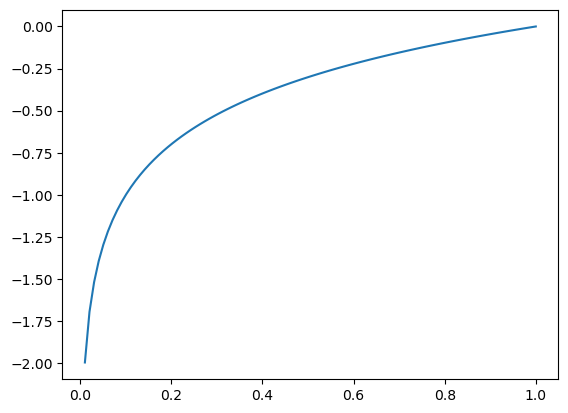

In [7]:
x = np.linspace(0, 1, 100)
plt.plot(x[1:], np.log10(x[1:]))

In [6]:
# cross entropy loss for use in classification problems
criterion = nn.CrossEntropyLoss()

The cross entropy loss function is common for classification tasks and is defined as follows:

$$
L = -\frac{1}{N} \sum_{n=1}^N \sum_{c=1}^C y_{n,c} \log(p_{n,c})
$$

Intuitively, we can see that, for a given training example, the probabilities will be zero for each class except for the one with the true label (since they are one-hot encoded). When $y_{n,c}=1$, the loss will be very large when $p_{n,c}$ is close to zero (due to the minus sign in front), and then loss will be small when $p_{n,c}$ is close to 1.

For comparison, we can see this is similar to the MSE loss function we used in out single- and multi-layer perceptrons.

$$
L = \frac{1}{N} \sum_{n=1}^N \sum_{c=1}^C (y_{n,c}-p_{n,c})^2
$$

With all these pieces in hand, we're ready to explore some of our approaches to avoid overfitting.

## Dropout

Dropout refers to the process of "dropping out" certain nodes in the network at random by setting their weights to 0 in one pass through the forward model. You'll recall that our linear layers are implemented with fully-connected nodes meaning all input features to a layer are connected to all output nodes via an individual weight. Dropping out is typicaly done on the fully-connected layers in a CNN but it may also be done in the convolutional layers.

Since this technique is quite common, it is built into `nn` module of PyTorch and we can slip this into our CNN:

In [8]:
# this class is identical to that used in the previous notebook
# add a dropout layer in the fully connected layers of the notebook
class ClassificationCNN(nn.Module):
    def __init__(self):
        super(ClassificationCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2) 
        )
        
        conv_output_size = 32 * (25) * (25)
        self.fc_layers = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(conv_output_size, 128), 
            nn.ReLU(),

            # add a dropout layer here
            nn.Dropout(p = 0.8),
            nn.Linear(128, 5)
        )

    # define the forward step
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

With this change, we can procede to training our model using our training function:

In [19]:
# redefine the model here in case cells are run 
# out of order for instructional purposes
model = ClassificationCNN().to(device)

# Adam optimizer for stochastic gradient descent
optimizer = optim.Adam(model.parameters(), lr=0.001)

# define the number of epochs
NUM_EPOCHS = 30

# call the training loop function we defined above
train_losses, test_losses = training_loop(model, optimizer, NUM_EPOCHS, train_loader, test_loader, printing = True)

Epoch 1/30 - Train Loss: 1.7051, Train Correct: 37/175 - Test Loss: 1.5559, Test Correct: 14/50 
Epoch 2/30 - Train Loss: 1.4822, Train Correct: 62/175 - Test Loss: 1.3485, Test Correct: 27/50 
Epoch 3/30 - Train Loss: 1.2493, Train Correct: 89/175 - Test Loss: 1.1240, Test Correct: 28/50 
Epoch 4/30 - Train Loss: 1.0926, Train Correct: 94/175 - Test Loss: 0.9754, Test Correct: 29/50 
Epoch 5/30 - Train Loss: 0.9918, Train Correct: 113/175 - Test Loss: 0.8706, Test Correct: 34/50 
Epoch 6/30 - Train Loss: 0.8688, Train Correct: 117/175 - Test Loss: 0.8045, Test Correct: 35/50 
Epoch 7/30 - Train Loss: 0.7233, Train Correct: 128/175 - Test Loss: 0.8108, Test Correct: 31/50 
Epoch 8/30 - Train Loss: 0.6953, Train Correct: 127/175 - Test Loss: 0.7455, Test Correct: 35/50 
Epoch 9/30 - Train Loss: 0.5970, Train Correct: 131/175 - Test Loss: 0.8108, Test Correct: 35/50 
Epoch 10/30 - Train Loss: 0.5022, Train Correct: 146/175 - Test Loss: 0.7443, Test Correct: 36/50 
Epoch 11/30 - Train Los

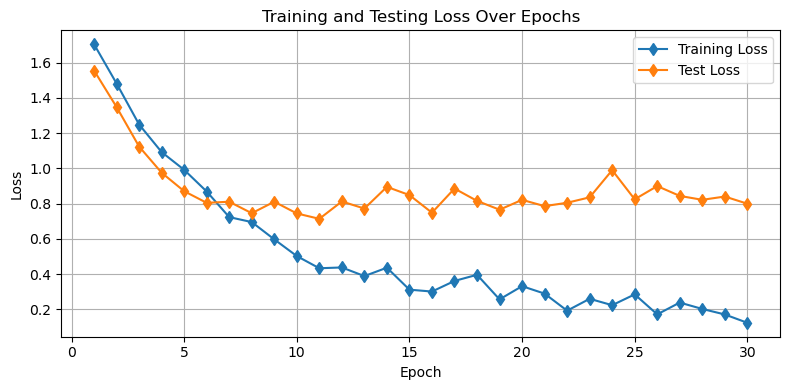

In [20]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, 'd-', label='Training Loss')
plt.plot(range(1, NUM_EPOCHS + 1), test_losses, 'd-', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Looking at the plot above, we can see that the drop-out procedure helped with our issue of overfitting! Now, we don't see an extreme increase in the test losses as the training is proceding.

### The Adaptive Moment Estimation Algorithm

In this lesson and the previous one, we've been using the following algorithm as our optimizer: `optim.Adam(model.parameters(), lr=0.001)`

Here, `Adam` (short for Adaptive Moment Estimation) is a gradient descent algorithm much like the (Stochastic) Gradient Descent algorithm (`SGD`) we've used in previous lessons. The difference here is that the `Adam` algorithm choose updates to weights in a "smarter way" than randomly taking steps toward the minimum of the loss function. This is done by computing the running mean and the variance of the gradients ss they are computed on each iteration. These quantities (or "moments") are used is used to scale the learning rate so that the steps are appropriately sized - e.g. large steps are taken when possible, but small steps are used there may be an issue of convergence.

### A peek at model performance on the validation set

Let's take a peek at how things are looking in our validation set:

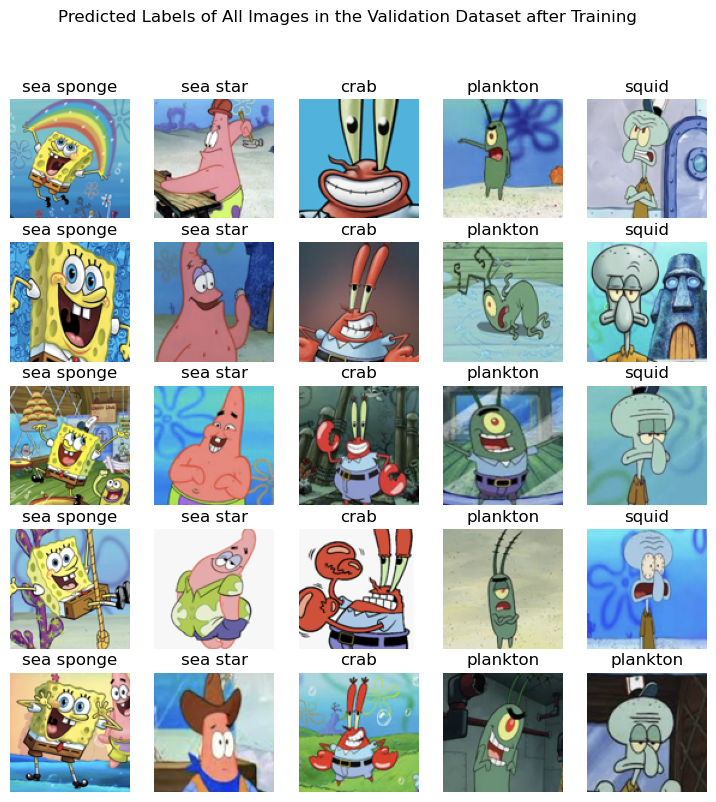

In [21]:
# define the species for each category
species = ['sea sponge','sea star','crab','plankton','squid']

# Set model to evaluation mode
model.eval()

# make a figure object
fig = plt.figure(figsize=(9,9))
gs = gridspec.GridSpec(5, len(species))

# loop through each species (column)
for s in range(len(species)):

    # loop through the image files
    file_list = os.listdir(os.path.join('Images','validate',str(s)))[:5]
    for file_count, file_name in enumerate(file_list):

        # load the image
        image = Image.open(os.path.join('Images','validate',str(s),file_name)).convert('RGB')
        input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension
        
        # get the predicted class
        with torch.no_grad():
            output = model(input_tensor)
            _, predicted = torch.max(output, 1)
        predicted_class = species[predicted.item()]

        # add the image to the plot with the prediction
        ax = fig.add_subplot(gs[file_count, s])
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(predicted_class)
        file_count +=1

plt.suptitle('Predicted Labels of All Images in the Validation Dataset after Training')
plt.show()

Looks pretty good - let's explore one other way we can improve our model to avoid overfitting.

## Data Augmentation
Data augmentation is the process of supplementing the training data set to include more training examples when the training examples do not exist. To create these artificial training examples, we will apply transformations to our existing set in such a way that the character of the image remains intact while the actual pixel values have changed. 

Since this augmentation procedure is quite common, the `torchvision` module is designed to give us a way to call upon typicial transformations. Let's have a look at a few of them:

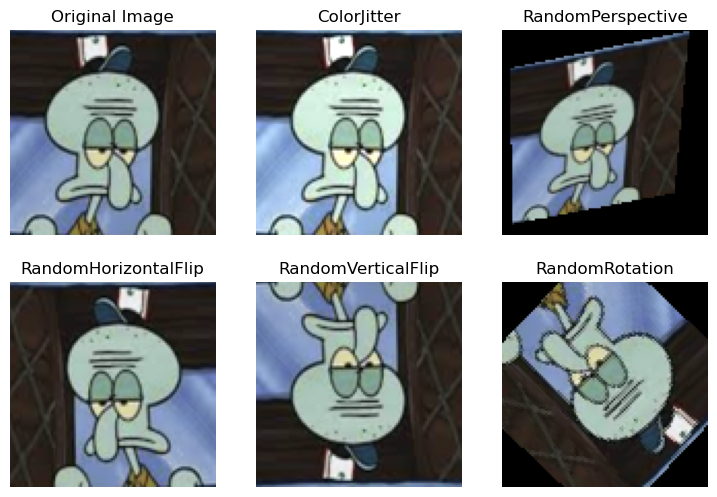

In [23]:
# read the last image from the validation set
image = Image.open(os.path.join('Images','validate',str(s),file_name)).convert('RGB')
input_tensor = transform(image).unsqueeze(0).to(device)
                                # ^ Add batch dimension

# define a list of augmentations
augmentations = [
                transforms.ColorJitter(brightness = 0.3, contrast = 0.3, saturation = 0.3, hue = 0.05),
                transforms.RandomPerspective(distortion_scale = 0.4, p = 1.0), 
                transforms.RandomHorizontalFlip(p = 1.0), 
                transforms.RandomVerticalFlip(p = 1.0), 
                transforms.RandomRotation(degrees = 180)
]
augmentation_names = ['ColorJitter', 'RandomPerspective', 'RandomHorizontalFlip', 'RandomVerticalFlip', 'RandomRotation']

# make a figure object
fig = plt.figure(figsize=(9,6))
gs = gridspec.GridSpec(2, 3)

# organize the plots of each image
ax = fig.add_subplot(gs[0,0])
ax.imshow(image)
ax.axis('off')
ax.set_title('Original Image')

for a, augmentation in enumerate(augmentations):
    transformed_image = augmentation(image)
    col = (a+1)%3
    row = (a+1)//3
    ax = fig.add_subplot(gs[(a+1)//3, (a+1)%3])
    ax.imshow(transformed_image)
    ax.axis('off')
    ax.set_title(augmentation_names[a])

plt.show()

Data augmentation can be used to build up more images in the training set, stored as additional files. Alternatively, we can build these random transformations directly into our data loader so that each time we load up a mini-batch, the images a modified before being passed through the network. 

Here, we will build in these transformations at random as the images are read in to PyTorch:

In [35]:
# training transform redefined
train_transform_augmented = transforms.Compose([

    # Apply some random flips and rotation
    transforms.RandomHorizontalFlip(p = 0.5), 
    transforms.RandomVerticalFlip(p = 0.5), 
    transforms.RandomRotation(degrees = 15),

    # Randomly apply color jitters or random perspectives
    transforms.RandomApply([
        transforms.ColorJitter(brightness = 0.3, contrast = 0.3, saturation = 0.3, hue = 0.05),
        transforms.RandomPerspective(distortion_scale = 0.4, p = 1.0),
    ], p = 0.5),

    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])
])

Now that we've re-defined our transform, let's redefine our data loader:

In [43]:
# make a data loader with the augmentation transform
train_dataset_augmented = datasets.ImageFolder(root=os.path.join('Images','test'), transform=train_transform_augmented)
train_loader_augmented = DataLoader(train_dataset_augmented, batch_size=BATCH_SIZE, shuffle=False)

Let's try our model with the new aumentation

In [47]:
# redefine the model here in case cells are run 
# out of order for instructional purposes
model = ClassificationCNN().to(device)

# Adam optimizer for stochastic gradient descent
optimizer = optim.Adam(model.parameters(), lr=0.001)

# define the number of epochs
NUM_EPOCHS = 100

# call the training loop function we defined above
train_losses, test_losses = training_loop(model, optimizer, NUM_EPOCHS, train_loader_augmented, test_loader, printing = True)

Epoch 1/100 - Train Loss: 2.5601, Train Correct: 3/50 - Test Loss: 1.6536, Test Correct: 10/50 
Epoch 2/100 - Train Loss: 1.6572, Train Correct: 11/50 - Test Loss: 1.5927, Test Correct: 12/50 
Epoch 3/100 - Train Loss: 1.6308, Train Correct: 10/50 - Test Loss: 1.5822, Test Correct: 21/50 
Epoch 4/100 - Train Loss: 1.6115, Train Correct: 9/50 - Test Loss: 1.5664, Test Correct: 22/50 
Epoch 5/100 - Train Loss: 1.6138, Train Correct: 11/50 - Test Loss: 1.5504, Test Correct: 21/50 
Epoch 6/100 - Train Loss: 1.5907, Train Correct: 9/50 - Test Loss: 1.5311, Test Correct: 22/50 
Epoch 7/100 - Train Loss: 1.5453, Train Correct: 18/50 - Test Loss: 1.5010, Test Correct: 22/50 
Epoch 8/100 - Train Loss: 1.5433, Train Correct: 15/50 - Test Loss: 1.4614, Test Correct: 24/50 
Epoch 9/100 - Train Loss: 1.5396, Train Correct: 17/50 - Test Loss: 1.4268, Test Correct: 27/50 
Epoch 10/100 - Train Loss: 1.4965, Train Correct: 25/50 - Test Loss: 1.3860, Test Correct: 29/50 
Epoch 11/100 - Train Loss: 1.413

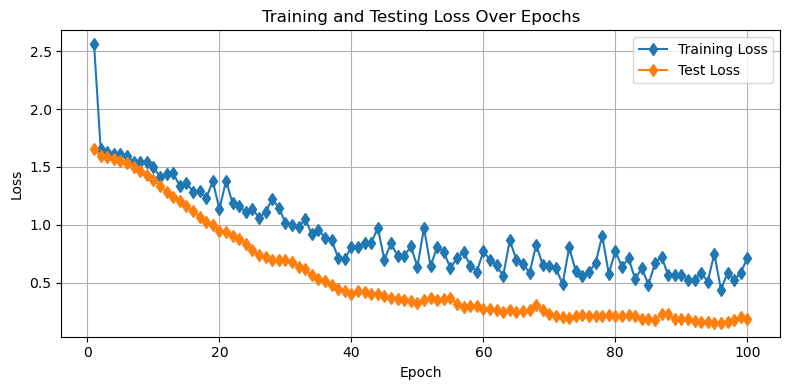

In [48]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, 'd-', label='Training Loss')
plt.plot(range(1, NUM_EPOCHS + 1), test_losses, 'd-', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

As we can see, the augmentation also helps yield a training which avoids overfitting.

As above, we can check on the performance of our model on the validation set.

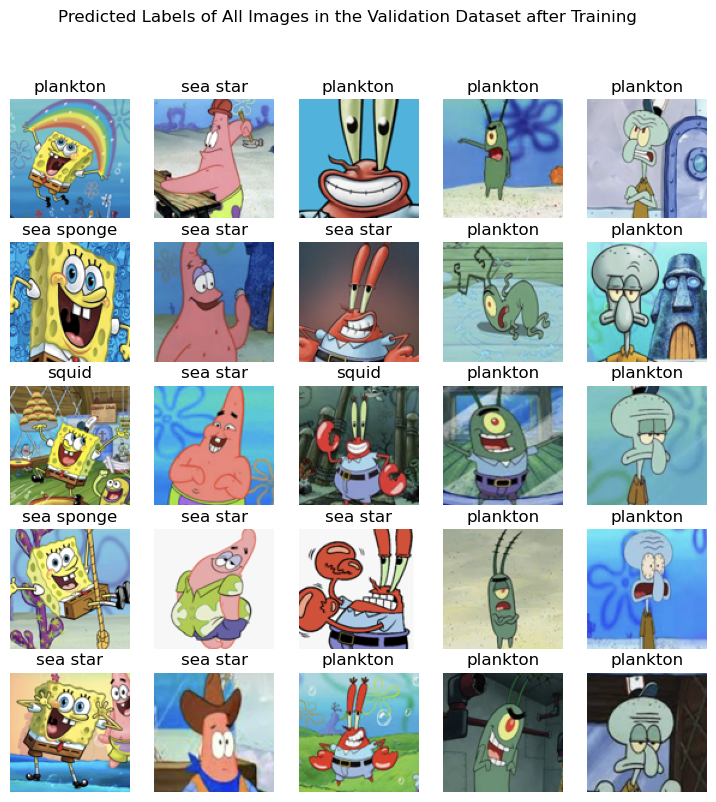

In [46]:
# define the species for each category
species = ['sea sponge','sea star','crab','plankton','squid']

# Set model to evaluation mode
model.eval()

# make a figure object
fig = plt.figure(figsize=(9,9))
gs = gridspec.GridSpec(5, len(species))

# loop through each species (column)
for s in range(len(species)):

    # loop through the image files
    file_list = os.listdir(os.path.join('Images','validate',str(s)))[:5]
    for file_count, file_name in enumerate(file_list):

        # load the image
        image = Image.open(os.path.join('Images','validate',str(s),file_name)).convert('RGB')
        input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension
        
        # get the predicted class
        with torch.no_grad():
            output = model(input_tensor)
            _, predicted = torch.max(output, 1)
        predicted_class = species[predicted.item()]

        # add the image to the plot with the prediction
        ax = fig.add_subplot(gs[file_count, s])
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(predicted_class)
        file_count +=1

plt.suptitle('Predicted Labels of All Images in the Validation Dataset after Training')
plt.show()

Again, we can see our model is working pretty well on the validation set.

## Try it for yourself!

Can you make a better model than we made above? See if you can reduce the losses even further by implementing one of the following:
- an additional convolutional layer
- an additional linear layer
- an additional drop-out
- variations in the augmentation

In [55]:
# code up your solution here
# this class is identical to that used in the previous notebook
# decrease droupout rate to 0.4 from 0.8, 100 epochs 
class ClassificationCNN(nn.Module):
    def __init__(self):
        super(ClassificationCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2) 
        )
        
        conv_output_size = 32 * (25) * (25)
        self.fc_layers = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(conv_output_size, 128), 
            nn.ReLU(),

            # add a dropout layer here
            nn.Dropout(p = 0.25),
            nn.Linear(128, 5)
        )

    # define the forward step
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x
        
# redefine the model here in case cells are run 
# out of order for instructional purposes
model = ClassificationCNN().to(device)

# Adam optimizer for stochastic gradient descent
optimizer = optim.Adam(model.parameters(), lr=0.001)

# define the number of epochs
NUM_EPOCHS = 200

# call the training loop function we defined above
train_losses, test_losses = training_loop(model, optimizer, NUM_EPOCHS, train_loader_augmented, test_loader, printing = True)

Epoch 1/200 - Train Loss: 4.2994, Train Correct: 0/50 - Test Loss: 1.7427, Test Correct: 17/50 
Epoch 2/200 - Train Loss: 1.6540, Train Correct: 10/50 - Test Loss: 1.6151, Test Correct: 10/50 
Epoch 3/200 - Train Loss: 1.6270, Train Correct: 17/50 - Test Loss: 1.6074, Test Correct: 14/50 
Epoch 4/200 - Train Loss: 1.6149, Train Correct: 10/50 - Test Loss: 1.6051, Test Correct: 12/50 
Epoch 5/200 - Train Loss: 1.6161, Train Correct: 10/50 - Test Loss: 1.6039, Test Correct: 12/50 
Epoch 6/200 - Train Loss: 1.6134, Train Correct: 11/50 - Test Loss: 1.6028, Test Correct: 12/50 
Epoch 7/200 - Train Loss: 1.6092, Train Correct: 12/50 - Test Loss: 1.6013, Test Correct: 13/50 
Epoch 8/200 - Train Loss: 1.6067, Train Correct: 13/50 - Test Loss: 1.5996, Test Correct: 14/50 
Epoch 9/200 - Train Loss: 1.6025, Train Correct: 15/50 - Test Loss: 1.5971, Test Correct: 18/50 
Epoch 10/200 - Train Loss: 1.6022, Train Correct: 14/50 - Test Loss: 1.5935, Test Correct: 18/50 
Epoch 11/200 - Train Loss: 1.6

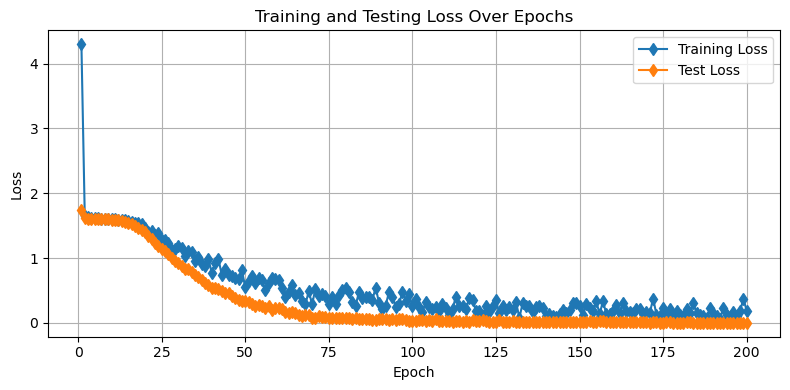

In [56]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, 'd-', label='Training Loss')
plt.plot(range(1, NUM_EPOCHS + 1), test_losses, 'd-', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

When you have a good solution, check in with a neighbor to see what changes they've implemented and how their model is performing. 